1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [6]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt

In [7]:
N = 5000

x_1 = np.random.normal(loc = 0., scale = 1., size = N)
x_2 = x_1 + np.random.normal(loc = 0., scale = 3., size = N)
x_3 = 2*x_1 + x_2

X = np.array([x_1, x_2, x_3])


M = np.cov(X)

print(np.shape(X))


(3, 5000)


In [8]:
l, V = np.linalg.eig(M)

print(l)
print(V)

[2.68776271e+01 1.83526038e-16 2.00288231e+00]
[[-0.11310889 -0.81649658  0.56616227]
 [-0.58029544 -0.40824829 -0.7046918 ]
 [-0.80651322  0.40824829  0.42763273]]


In [9]:
U, D, Vt = np.linalg.svd(M)

print(D)
print(U)

# linalg.svd sorts the eigenvalues (and the respective eigenvectors) in descending order.

[2.68776271e+01 2.00288231e+00 3.78049499e-16]
[[-0.11310889  0.56616227 -0.81649658]
 [-0.58029544 -0.7046918  -0.40824829]
 [-0.80651322  0.42763273  0.40824829]]


In [10]:
tot = np.sum(D)
for li, vi in zip(D, U):
    print(vi)
    print('Proportion of variance explained for the eigenvalue ' + str(li) + ' = ' + str(li/tot))
    

[-0.11310889  0.56616227 -0.81649658]
Proportion of variance explained for the eigenvalue 26.877627091994956 = 0.9306493427090885
[-0.58029544 -0.7046918  -0.40824829]
Proportion of variance explained for the eigenvalue 2.0028823099190887 = 0.06935065729091151
[-0.80651322  0.42763273  0.40824829]
Proportion of variance explained for the eigenvalue 3.7804949912795543e-16 = 1.3090125726899414e-17


We can obtain the 99% of the total variability by considering the eigenvectors related to the first and the third eigenvalue. This result makes sense: x_2 is dependant on x_1 and x_3 is a linear combination of the first two, so the presence of a high-proportion term (93%) followed by a small-proportion one (6%) and a practically null term can be explained by the structure of the dataset.

In [11]:
print('Percent of the total variability obtained by considering the first two bigger eigenvalues: ' + str(D[0]/tot + D[1]/tot))

Percent of the total variability obtained by considering the first two bigger eigenvalues: 1.0


In [12]:
L = np.diag(D)
L[2,2] = 0


Xp = np.dot(L,X)

print(Xp)

[[  1.54718321  56.00519807   3.43697067 ...   7.13234498 -59.35855288
    8.26770652]
 [  3.25713595   5.21657312  -0.51015296 ...  -0.90851016   2.0408464
   -2.35604018]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]


Text(0.5, 1.0, '(2,0) projection')

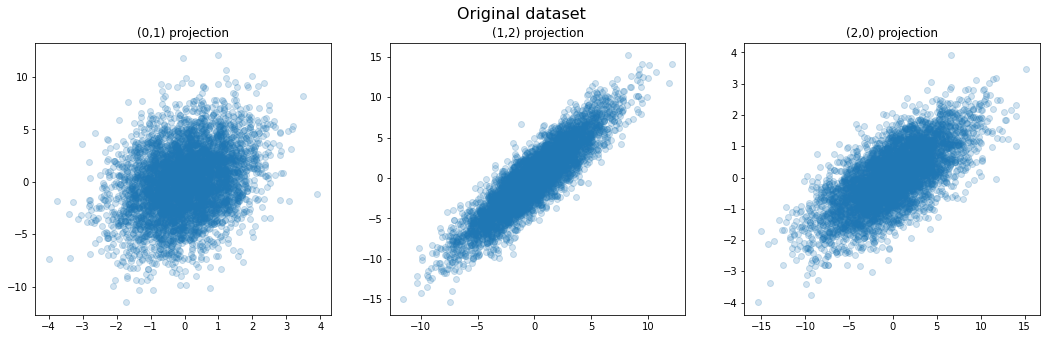

In [24]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (18,5))

fig.suptitle('Original dataset', fontsize = 16)

ax1.scatter(X[0,:], X[1,:], alpha = 0.2)
ax1.set_title('(0,1) projection')


ax2.scatter(X[1,:], X[2,:], alpha = 0.2)
ax2.set_title('(1,2) projection')

    
ax3.scatter(X[2,:], X[0,:], alpha = 0.2)
ax3.set_title('(2,0) projection')

Text(0.5, 1.0, '(2,0) projection')

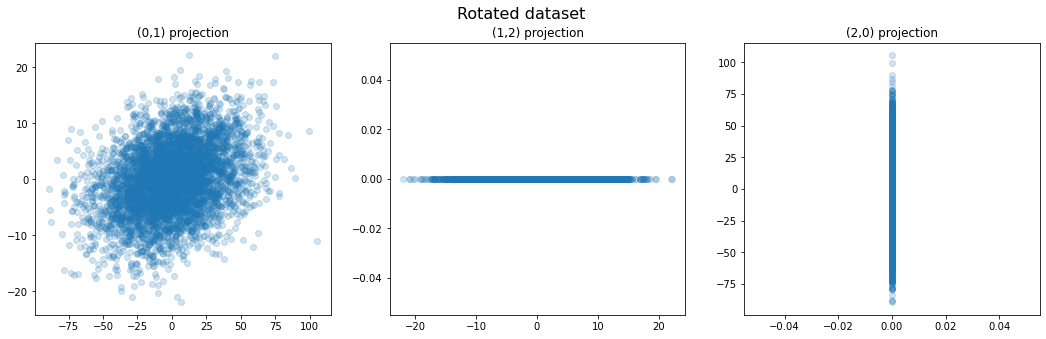

In [9]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (18,5))

fig.suptitle('Rotated dataset', fontsize = 16)

scale_factor = 3

ax1.scatter(Xp[0,:], Xp[1,:], alpha = 0.2)
ax1.set_title('(0,1) projection')

ax2.scatter(Xp[1,:], Xp[2,:], alpha = 0.2)
ax2.set_title('(1,2) projection')

ax3.scatter(Xp[2,:], Xp[0,:], alpha = 0.2)
ax3.set_title('(2,0) projection')

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [26]:
std = 1/50
X = np.array([x_1, x_2, x_3])


for i in range(0,10):
    X = np.vstack((X, np.random.normal(loc = 0., scale = std, size = N)))
    

M = np.cov(X)

U, D, Vt = np.linalg.svd(M)

In [27]:
tot = np.sum(D)

print('Percent of the total variability obtained by considering the first two bigger eigenvalues: ' + str(D[0]/tot + D[1]/tot))

Percent of the total variability obtained by considering the first two bigger eigenvalues: 0.9998617030828563


The percentage of the total variability obtained by considering the first two bigger eigenvalues decreased by inserting the random noise (in the previous example, the contribution of the third eigenvalue was completely negligible).

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


Text(0, 0.5, 'y')

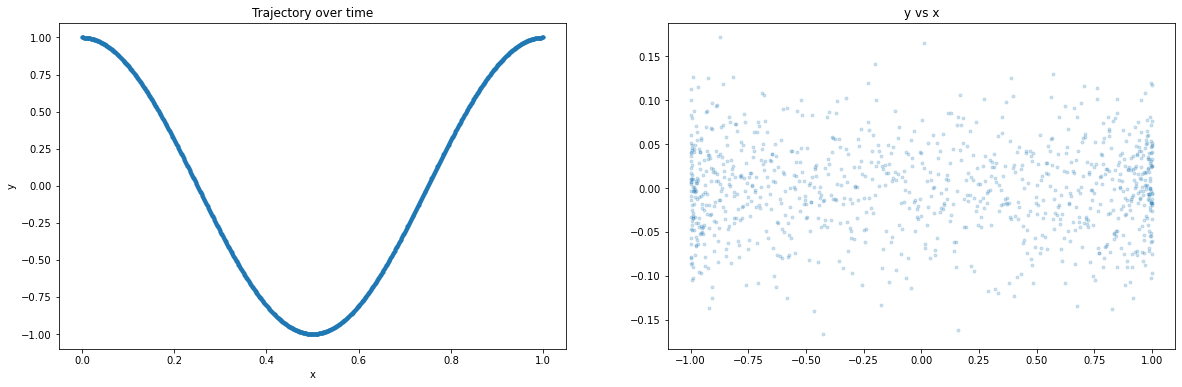

In [60]:
N = 1000

t = np.linspace(0,1,N)
x = np.cos(2*np.pi*t)

y = np.random.normal(loc = 0, scale = 0.05, size = N)

z = np.zeros(N)

X = np.array([x, y, z])


fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (20, 6))

ax1.scatter(t, x, marker = '.')
ax1.set_title('Trajectory over time')
ax1.set_xlabel('t')
ax1.set_ylabel('x')

ax2.scatter(x,y, marker = '.', alpha = 0.2)
ax2.set_title('y vs x')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

In [56]:
#PCA
M = np.cov(X)

U, D, V = np.linalg.svd(M)

trace = np.sum(D)
for li, vi in zip(D,U):
    print(li)
    print('Proportion of variance explained for the eigenvalue ' + str(li) + ' = ' + str(li/trace))

0.5010023567310484
Proportion of variance explained for the eigenvalue 0.5010023567310484 = 0.995169465491503
0.002431856338992876
Proportion of variance explained for the eigenvalue 0.002431856338992876 = 0.00483053450849702
0.0
Proportion of variance explained for the eigenvalue 0.0 = 0.0


Text(0.5, 1.0, '(2,0) projection')

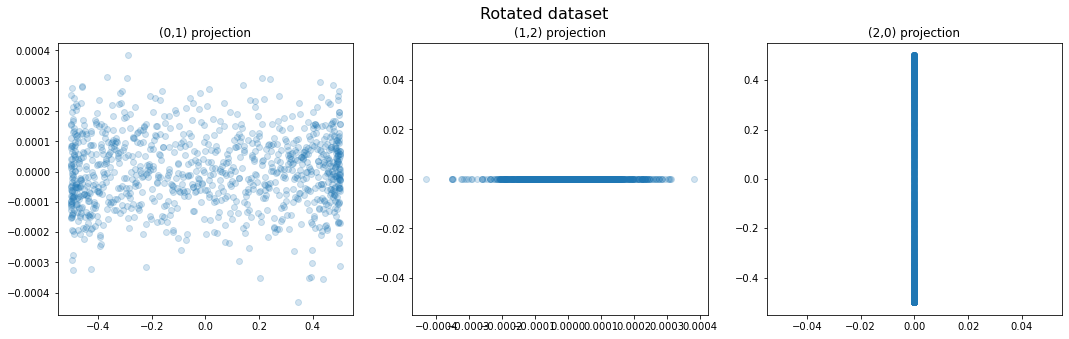

In [59]:
L = np.diag(D)

Xp = np.dot(L,X)

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (18,5))

fig.suptitle('Rotated dataset', fontsize = 16)

scale_factor = 3

ax1.scatter(Xp[0,:], Xp[1,:], alpha = 0.2)
ax1.set_title('(0,1) projection')

ax2.scatter(Xp[1,:], Xp[2,:], alpha = 0.2)
ax2.set_title('(1,2) projection')

ax3.scatter(Xp[2,:], Xp[0,:], alpha = 0.2)
ax3.set_title('(2,0) projection')

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [1]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/LaboratoryOfComputationalPhysics_Y3
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/LaboratoryOfComputationalPhysics_Y3

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [24]:
import pandas as pd

In [64]:
filename = 'magic04.data'

data = pd.read_csv(filename, header = None)

